Any learning algorithm will always have strengths and weaknesses: a single model is unlikely to fit every possible scenario. Ensembles combine multiple models to achieve higher generalization performance than any of the constituent models is capable of. How do we assemble the weak learners? We can use some sequential heuristics. For instance, given the current collection of models, we can add one more based on where that particular model performs well. Alternatively, we can look at all the correlations of the predictions between all models, and optimize for the most uncorrelated predictors. Since this latter is a global approach, it naturally maps to a quantum computer. But first, let's take a look a closer look at loss functions and regularization, two key concepts in machine learning.

# Loss Functions and Regularization

If you can solve a problem by a classical computer -- let that be a laptop or a massive GPU cluster -- there is little value in solving it by a quantum computer that costs ten million dollars. The interesting question in quantum machine learning is whether there are problems in machine learning and AI that fit quantum computers naturally, but are challenging on classical hardware. This, however, requires a good understanding of both machine learning and contemporary quantum computers.

In this course, we primarily focus on the second aspect, since there is no shortage of educational material on classical machine learning. However, it is worth spending a few minutes on going through some basics.

Let us take a look at the easiest possible problem: the data points split into two, easily distinguishable sets. We randomly generate this data set:

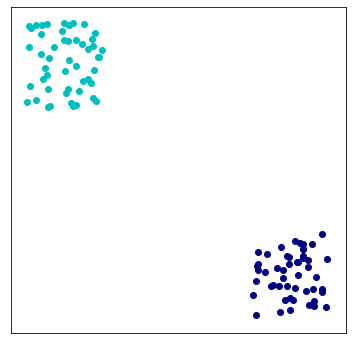

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

c1 = np.random.rand(50, 2)/5
c2 = (-0.6, 0.5) + np.random.rand(50, 2)/5
data = np.concatenate((c1, c2))
labels = np.array([0] * 50 + [1] *50)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:50, 0], data[:50, 1], color='navy')
plt.scatter(data[50:, 0], data[50:, 1], color='c');

Let's shuffle the data set into a training set that we are going to optimize over (2/3 of the data), and a test set where we estimate our generalization performance. 

In [2]:
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]
y_train = labels[idx_train]
y_test = labels[idx_test]

We will use the package `scikit-learn` to train various machine learning models.

In [3]:
import sklearn
import sklearn.metrics
metric = sklearn.metrics.accuracy_score

Let's train a perceptron, which has a linear loss function $\frac{1}{N}\sum_{i=1}^N |h(x_i)-y_i)|$:

In [4]:
from sklearn.linear_model import Perceptron
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  1.00
accuracy (test):  1.00


It does a great job. It is a linear model, meaning its decision surface is a plane. Our dataset is separable by a plane, so let's try another linear model, but this time a support vector machine. If you eyeball our dataset, you will see that to define the separation between the two classes, actually only a few points close to the margin are relevant. These are called support vectors and support vector machines aim to find them. Its objective function measures The $C$ hyperparameter controls a regularization term that penalizes the objective for the number of support vectors:

In [5]:
from sklearn.svm import SVC
model_2 = SVC(kernel='linear', C=1)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
print('Number of support vectors:', sum(model_2.n_support_))

accuracy (train):  1.00
accuracy (test):  1.00
Number of support vectors: 10


It picks only a few datapoints out of the hundred. Let's change the hyperparameter to reduce the penalty:

In [6]:
model_2 = SVC(kernel='linear', C=0.01)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
print('Number of support vectors:', sum(model_2.n_support_))

accuracy (train):  0.55
accuracy (test):  0.41
Number of support vectors: 60


You can see that the model gets confused by using two many datapoints in the final classifier. This is one example where regularization helps.

# Ensemble methods

Ensembles yield better results when there is considerable diversity among the base classifiers. If diversity is sufficient, base classifiers make different errors, and a strategic combination may reduce the total error, ideally improving generalization performance. A constituent model in an ensemble is also called a base classifier or weak learner, and the composite model a strong learner.

The generic procedure of ensemble methods has two steps. First, develop a set of base classifiers from the training data. Second, combine them to form the ensemble. In the simplest combination, the base learners vote, and the label prediction is based on majority. More involved methods weigh the votes of the base learners. 

Let us import some packages and define our figure of merit as accuracy in a balanced dataset.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.metrics
%matplotlib inline

metric = sklearn.metrics.accuracy_score

We generate a random dataset of two classes that form concentric circles:

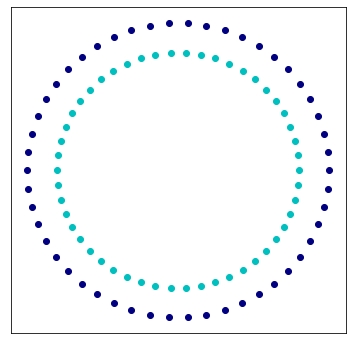

In [8]:
np.random.seed(0)
data, labels = sklearn.datasets.make_circles()
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]

y_train = 2 * labels[idx_train] - 1  # binary -> spin
y_test = 2 * labels[idx_test] - 1

scaler = sklearn.preprocessing.StandardScaler()
normalizer = sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='navy')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='c');

Let's train a perceptron:

In [9]:
from sklearn.linear_model import Perceptron
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  0.44
accuracy (test):  0.65


Since its decision surface is linear, we get a poor accuracy. Would a support vector machine with a nonlinear kernel fare better?

In [10]:
from sklearn.svm import SVC
model_2 = SVC(kernel='rbf')
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))

accuracy (train):  0.64
accuracy (test):  0.24


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


It performs better on the training set, but at the cost of extremely poor generalization. 

Boosting is an ensemble method that explicitly seeks models that complement one another. The variation between boosting algorithms is how they combine weak learners. Adaptive boosting (AdaBoost) is a popular method that combines the weak learners in a sequential manner based on their individual accuracies. It has a convex objective function that does not penalize for complexity: it is likely to include all available weak learners in the final ensemble. Let's train AdaBoost with a few weak learners:

In [11]:
from sklearn.ensemble import AdaBoostClassifier
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


Its performance is marginally better than that of the SVM.

# QBoost

The idea of Qboost is that optimization on a quantum computer is not constrained to convex objective functions, therefore we can add arbitrary penalty terms and rephrase our objective [[1](#1)]. Qboost solves the following problem:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}\left(\sum_{k=1}^{K}w_kh_k(x_i)-
y_i\right)^2+\lambda\|w\|_0\right),
$$

where $h_k(x_i)$ is the prediction of the weak learner $k$ for a training instance $k$. The weights in this formulation are binary, so this objective function is already maps to an Ising model. The regularization in the $l_0$ norm ensures sparsity, and it is not the kind of regularization we would consider classically: it is hard to optimize with this term on a digital computer.

Let us expand the quadratic part of the objective:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}
\left( \left(\sum_{k=1}^{K} w_k h_k(x_i)\right)^{2} -
2\sum_{k=1}^{K} w_k h_k(\mathbf{x}_i)y_i + y_i^{2}\right) + \lambda \|w\|_{0}
\right).
$$

Since $y_i^{2}$ is just a constant offset, the optimization reduces to

$$
\mathrm{argmin}_{w} \left(
\frac{1}{N}\sum_{k=1}^{K}\sum_{l=1}^{K} w_k w_l
\left(\sum_{i=1}^{N}h_k(x_i)h_l(x_i)\right) - 
\frac{2}{N}\sum_{k=1}^{K}w_k\sum_{i=1}^{N} h_k(x_i)y_i +
\lambda \|w\|_{0} \right).
$$

This form shows that we consider all correlations between the predictions of the weak learners: there is a summation of $h_k(x_i)h_l(x_i)$. Since this term has a positive sign, we penalize for correlations. On the other hand, the correlation with the true label, $h_k(x_i)y_i$, has a negative sign. The regularization term remains unchanged.

Let us consider all three models from the previous section as weak learners.

In [12]:
models = [model_1, model_2, model_3]

We calculate their predictions and set $\lambda$ to 1. The predictions are scaled to reflecting the averaging in the objective.

In [13]:
n_models = len(models)

predictions = np.array([h.predict(X_train) for h in models], dtype=np.float64)
# scale hij to [-1/N, 1/N]
predictions *= 1/n_models

λ = 1

We create the quadratic binary optimization of the objective function as we expanded above:

In [14]:
w = np.dot(predictions, predictions.T)
wii = len(X_train) / (n_models ** 2) + λ - 2 * np.dot(predictions, y_train)
w[np.diag_indices_from(w)] = wii
W = {}
for i in range(n_models):
    for j in range(i, n_models):
        W[(i, j)] = w[i, j]

We solve the quadratic binary optimization with simulated annealing and read out the optimal weights:

In [15]:
import dimod
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample_qubo(W, num_reads=10)
weights = list(response.first.sample.values())

We define a prediction function to help with measuring accuracy:

In [16]:
def predict(models, weights, X):

    n_data = len(X)
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        y0 = weights[i] * h.predict(X)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

In [17]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


The accuracy co-incides with our strongest weak learner's, the AdaBoost model. Looking at the optimal weights, this is apparent:

In [18]:
weights

[0, 0, 1]

Only AdaBoost made it to the final ensemble. The first two models perform poorly and their predictions are correlated. Yet, if you remove regularization by setting $\lambda=0$ above, the second model also enters the ensemble, decreasing overall performance. This shows that the regularization is in fact important.

# Solving by QAOA

Since eventually our problem is just an Ising model, we can also solve it on a gate-model quantum computer by QAOA. Let us explicitly map the binary optimization to the Ising model:

In [19]:
h, J, offset = dimod.qubo_to_ising(W)

We have to translate the Ising couplings to be suitable for solving by the QAOA routine:

In [20]:
from pyquil import Program, api
from pyquil.paulis import PauliSum, PauliTerm
from scipy.optimize import fmin_bfgs
from grove.pyqaoa.qaoa import QAOA
from forest_tools import *
qvm_server, quilc_server, fc = init_qvm_and_quilc()
qvm = api.QVMConnection(endpoint=fc.sync_endpoint, compiler_endpoint=fc.compiler_endpoint)

num_nodes = w.shape[0]
ising_model = []
for i in range(num_nodes):
    ising_model.append(PauliSum([PauliTerm("Z", i, h[i])]))
    for j in range(i+1, num_nodes):
        ising_model.append(PauliSum([PauliTerm("Z", i, J[i, j]) * PauliTerm("Z", j, 1.0)]))

ModuleNotFoundError: No module named 'pyquil'

Next we run the optimization:

In [ ]:
p = 1
Hm = [PauliSum([PauliTerm("X", i, 1.0)]) for i in range(num_nodes)]
qaoa = QAOA(qvm,
            qubits=range(num_nodes),
            steps=p,
            ref_ham=Hm,
            cost_ham=ising_model,
            store_basis=True,
            minimizer=fmin_bfgs,
            minimizer_kwargs={'maxiter': 50})
ν, γ = qaoa.get_angles()
program = qaoa.get_parameterized_program()(np.hstack((ν, γ)))
measures = qvm.run_and_measure(program, range(num_nodes), trials=100)
measures = np.array(measures)

Let's look at the solutions found:

In [ ]:
hist = plt.hist([str(m) for m in measures])

Finally, we extract the most likely solution:

In [ ]:
count = np.unique(measures, return_counts=True, axis=0)
weights = count[0][np.argmax(count[1])]

Let's see the weights found by QAOA:

In [ ]:
weights

And the final accuracy:

In [ ]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

# References

[1] Neven, H., Denchev, V.S., Rose, G., Macready, W.G. (2008). [Training a binary classifier with the quantum adiabatic algorithm](https://arxiv.org/abs/0811.0416). *arXiv:0811.0416*.  <a id='1'></a>